In [ ]:
#Binary Classification of fetal ultrasound images using a InceptionNetV3 Architecture and Non-Segmented dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
import pathlib

train_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\Dataset\\Training'

val_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\Dataset\\Testing'

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 720 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 180 files belonging to 2 classes.


In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./225)

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

batch_normalization_58 (BatchNo (None, 17, 17, 192)  576         conv2d_58[0][0]                  
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 17, 17, 192)  576         conv2d_59[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 17, 17, 192)  0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 17, 17, 192)  0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 17, 17, 192)  0           batch_normalization_58[0][0]     
__________________________________________________________________________________________________
activation

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [19]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 33s 4s/step - loss: 0.7265 - accuracy: 0.4899


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
23/23 [==============================] - 149s 5s/step - loss: 0.7047 - accuracy: 0.5028 - val_loss: 0.6761 - val_accuracy: 0.5270
Epoch 2/50
23/23 [==============================] - 121s 5s/step - loss: 0.6882 - accuracy: 0.5097 - val_loss: 0.6519 - val_accuracy: 0.5541
Epoch 3/50
23/23 [==============================] - 122s 5s/step - loss: 0.6746 - accuracy: 0.5278 - val_loss: 0.6382 - val_accuracy: 0.5946
Epoch 4/50
23/23 [==============================] - 119s 5s/step - loss: 0.6617 - accuracy: 0.5764 - val_loss: 0.6314 - val_accuracy: 0.5811
Epoch 5/50
23/23 [==============================] - 120s 5s/step - loss: 0.6562 - accuracy: 0.5528 - val_loss: 0.6063 - val_accuracy: 0.6014
Epoch 6/50
23/23 [==============================] - 121s 5s/step - loss: 0.6291 - accuracy: 0.6194 - val_loss: 0.6036 - val_accuracy: 0.5946
Epoch 7/50
23/23 [==============================] - 121s 5s/step - loss: 0.6300 - accuracy: 0.5806 - val_loss: 0.5900 - val_accuracy: 0.6014
Epoch 8/50
23

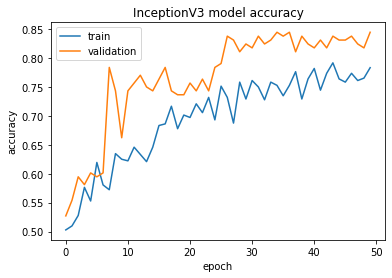

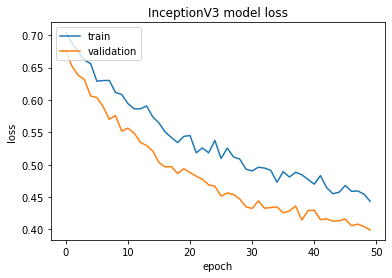

In [22]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-accuracy-InceptionV3-(4).svg')
plt.show()
    
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-loss-InceptionV3-(4).svg')
plt.show()


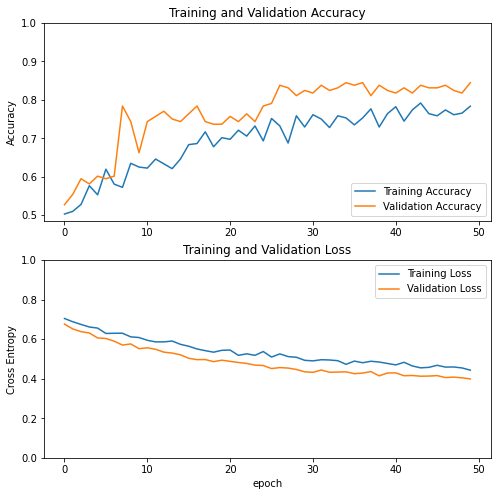

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()